In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from deepface import DeepFace
from deepface.commons import functions
import matplotlib.pyplot as plt

#!pip install cassandra-driver
from cassandra.cluster import Cluster

# Face recognition model

In [2]:
model = DeepFace.build_model("Facenet")

# Create facial database locally

In [3]:
facial_img_paths = []
#Available at: https://github.com/serengil/deepface/tree/master/tests/dataset
for root, directory, files in os.walk("deepface/tests/dataset"):
    for file in files:
        if '.jpg' in file:
            facial_img_paths.append(root+"/"+file)

In [4]:
instances = []

for i in tqdm(range(0, len(facial_img_paths))):
    facial_img_path = facial_img_paths[i]
    facial_img = functions.preprocess_face(facial_img_path, target_size = (160, 160))
    
    embedding = model.predict(facial_img)[0]
    
    instance = []
    instance.append(facial_img_path)
    instance.append(embedding)
    instances.append(instance)

100%|██████████| 60/60 [00:27<00:00,  2.14it/s]


In [5]:
df = pd.DataFrame(instances, columns = ["img_name", "embedding"])

In [6]:
df.head()

,img_name,embedding
0,deepface/tests/dataset/img1.jpg,"[1.0574055, 1.0961407, 1.2643185, -1.6389996, ..."
1,deepface/tests/dataset/img10.jpg,"[-0.32284275, 1.3187261, 1.242616, -1.4587235,..."
2,deepface/tests/dataset/img11.jpg,"[0.28591383, 0.35173756, 2.1035275, -1.4823748..."
3,deepface/tests/dataset/img12.jpg,"[-0.15722206, 2.2241635, -0.8684032, -1.483796..."
4,deepface/tests/dataset/img13.jpg,"[-1.2929415, -0.8253571, -1.7417858, -0.585865..."


# Connect to Cassandra

In [7]:
cluster = Cluster(['127.0.0.1'], port=9042)

In [8]:
#connect deepface database
session = cluster.connect('deepface', wait_for_all_pools = True)

In [9]:
session.execute('DROP TABLE IF EXISTS deepface.embeddings;')

In [10]:
session.execute('CREATE TABLE deepface.embeddings(img_id int PRIMARY KEY, img_name text, embedding list<double>);')

# Store local embeddings in cassandra

In [11]:
for index, instance in tqdm(df.iterrows(), total = df.shape[0]):
    img_name = instance["img_name"]
    embedding = instance["embedding"].tolist()    
    statement = "insert into deepface.embeddings (img_id, img_name, embedding) values (%d, '%s', %s);" % (index, img_name, embedding)
    
    session.execute(statement)

100%|██████████| 60/60 [00:00<00:00, 104.89it/s]


# Target

In [12]:
target_img_path = "target.png"
target_img = functions.preprocess_face(target_img_path, target_size = (160, 160))

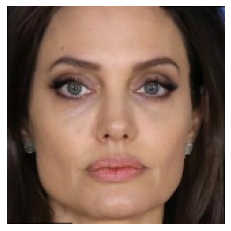

In [13]:
plt.imshow(target_img[0][:,:,::-1])
plt.axis('off')
plt.show()

In [14]:
target_embedding = model.predict(target_img)[0].tolist()

# Face recognition - client side

This approach is mainly based on retrieving embeddings of facial database from cassandra, then find distance values for each item in the client side.

In [16]:
rows = session.execute('SELECT * FROM deepface.embeddings')

instances = []
for row in rows:
    instance = []
    instance.append(row.img_name)
    instance.append(row.embedding)
    instances.append(instance)

In [17]:
retrieved_df = pd.DataFrame(instances, columns = ["img_name", "embedding"])

In [18]:
retrieved_df.head()

,img_name,embedding
0,deepface/tests/dataset/img31.jpg,"[0.30395060777664185, 0.37859517335891724, -0...."
1,deepface/tests/dataset/img6.jpg,"[0.04825747758150101, 1.1616168022155762, 1.37..."
2,deepface/tests/dataset/img62.jpg,"[-0.8223543167114258, -1.1515120267868042, -0...."
3,deepface/tests/dataset/img40.jpg,"[-1.9303354024887085, 0.4493763744831085, 0.08..."
4,deepface/tests/dataset/img14.jpg,"[-1.323629379272461, -0.89812171459198, -1.916..."


In [19]:
retrieved_df.shape

(60, 2)

In [20]:
#storing target as a column requires to duplicate it number of row times
target_duplicated = np.array([target_embedding,]*retrieved_df.shape[0])

In [21]:
target_duplicated.shape

(60, 128)

In [22]:
retrieved_df['target'] = target_duplicated.tolist()

In [23]:
retrieved_df.head()

,img_name,embedding,target
0,deepface/tests/dataset/img31.jpg,"[0.30395060777664185, 0.37859517335891724, -0....","[-0.352205753326416, 0.4047847092151642, 0.692..."
1,deepface/tests/dataset/img6.jpg,"[0.04825747758150101, 1.1616168022155762, 1.37...","[-0.352205753326416, 0.4047847092151642, 0.692..."
2,deepface/tests/dataset/img62.jpg,"[-0.8223543167114258, -1.1515120267868042, -0....","[-0.352205753326416, 0.4047847092151642, 0.692..."
3,deepface/tests/dataset/img40.jpg,"[-1.9303354024887085, 0.4493763744831085, 0.08...","[-0.352205753326416, 0.4047847092151642, 0.692..."
4,deepface/tests/dataset/img14.jpg,"[-1.323629379272461, -0.89812171459198, -1.916...","[-0.352205753326416, 0.4047847092151642, 0.692..."


In [24]:
def findEuclideanDistance(row):
    source = np.array(row['embedding'])
    target = np.array(row['target'])
    
    distance = (source - target)
    return np.sqrt(np.sum(np.multiply(distance, distance)))

In [25]:
retrieved_df['distance'] = retrieved_df.apply(findEuclideanDistance, axis = 1)

In [26]:
# threshold for facenet and euclidean pair is 10.
# Ref: https://github.com/serengil/deepface/blob/master/deepface/commons/distance.py
retrieved_df = retrieved_df[retrieved_df['distance'] <= 10]

In [27]:
retrieved_df = retrieved_df.sort_values(by = ['distance'])

In [28]:
retrieved_df

,img_name,embedding,target,distance
13,deepface/tests/dataset/img2.jpg,"[-0.11715236306190491, 0.42001163959503174, 0....","[-0.352205753326416, 0.4047847092151642, 0.692...",7.091029
14,deepface/tests/dataset/img10.jpg,"[-0.3228427469730377, 1.3187260627746582, 1.24...","[-0.352205753326416, 0.4047847092151642, 0.692...",7.736472
1,deepface/tests/dataset/img6.jpg,"[0.04825747758150101, 1.1616168022155762, 1.37...","[-0.352205753326416, 0.4047847092151642, 0.692...",8.416993
54,deepface/tests/dataset/img4.jpg,"[-0.23827597498893738, 0.5569553375244141, 1.8...","[-0.352205753326416, 0.4047847092151642, 0.692...",8.604489
39,deepface/tests/dataset/img7.jpg,"[-0.20119434595108032, 1.5051518678665161, 0.8...","[-0.352205753326416, 0.4047847092151642, 0.692...",8.693473
21,deepface/tests/dataset/img11.jpg,"[0.2859138250350952, 0.3517375588417053, 2.103...","[-0.352205753326416, 0.4047847092151642, 0.692...",8.994483
20,deepface/tests/dataset/img1.jpg,"[1.0574054718017578, 1.096140742301941, 1.2643...","[-0.352205753326416, 0.4047847092151642, 0.692...",9.616125


# Face recognition - server side

This approach is mainly based on sending the target embedding to cassandra and expect cassandra to find distances.

Unfortunately, we cannot add where clause or order results based on calculated columns in cassandra. 

That's why, we have to filter distant ones and sort them in the client side 

In [29]:
session.execute("DROP FUNCTION IF EXISTS deepface.euclidean;")

session.execute("CREATE FUNCTION euclidean(source list<double>, target list<double>)"\
    "CALLED ON NULL INPUT RETURNS double LANGUAGE java AS '"\
    "double  distance = 0;"\
    "for (int i=0;i<source.size();i++){"\
    "    double p = source.get(i);"\
    "    double q = target.get(i);"\
    "    distance = distance + (p - q) * (p - q);"\
    "}"\
    "distance = java.lang.Math.sqrt(distance);"\
    "return distance;"\
    "';"
)

In [30]:
statement = 'SELECT img_name, deepface.euclidean(embedding, %s) as distance ' \
            'FROM deepface.embeddings' % (target_embedding)

rows = session.execute(statement)

instances = []
for row in rows:
    instance = []
    instance.append(row.img_name)
    instance.append(row.distance)
    instances.append(instance)

In [31]:
result_df = pd.DataFrame(instances, columns = ["img_name", "distance"])

In [32]:
# threshold for facenet and euclidean pair is 10.
# Ref: https://github.com/serengil/deepface/blob/master/deepface/commons/distance.py

result_df = result_df[result_df['distance'] < 10]

In [35]:
result_df = result_df.sort_values(by = ["distance"]).reset_index(drop = True)

In [36]:
result_df

,img_name,distance
0,deepface/tests/dataset/img2.jpg,7.091029
1,deepface/tests/dataset/img10.jpg,7.736472
2,deepface/tests/dataset/img6.jpg,8.416993
3,deepface/tests/dataset/img4.jpg,8.604489
4,deepface/tests/dataset/img7.jpg,8.693473
5,deepface/tests/dataset/img11.jpg,8.994483
6,deepface/tests/dataset/img1.jpg,9.616125


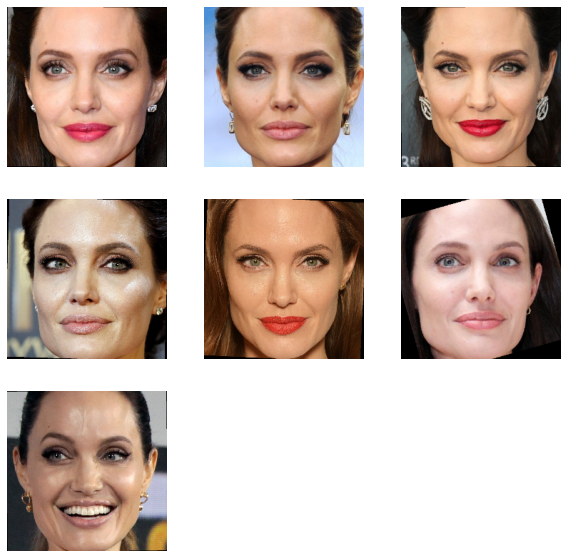

In [37]:
fig = plt.figure(figsize = (10, 10))

for index, instance in result_df.iterrows():
    img_name = instance["img_name"]
    distance = instance["distance"]
    
    ax = fig.add_subplot(3, 3, index + 1)
    
    img = functions.preprocess_face(img_name)[0]
    plt.imshow(img[:, :, ::-1])
    plt.axis('off')

plt.show()

# Validate results

In [41]:
val_df = DeepFace.find(img_path = target_img_path, db_path = "deepface/tests/dataset"
              , model_name = 'Facenet', model = model, distance_metric = 'euclidean'
              , detector_backend = 'opencv')

Analyzing:   0%|          | 0/1 [00:00<?, ?it/s]

Already built model is passed
There are  60  representations found in  representations_facenet.pkl


Analyzing: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

find function lasts  0.25600123405456543  seconds


In [42]:
val_df

,identity,Facenet_euclidean
0,deepface/tests/dataset/img2.jpg,7.091029
1,deepface/tests/dataset/img10.jpg,7.736472
2,deepface/tests/dataset/img6.jpg,8.416993
3,deepface/tests/dataset/img4.jpg,8.604489
4,deepface/tests/dataset/img7.jpg,8.693473
5,deepface/tests/dataset/img11.jpg,8.994483
6,deepface/tests/dataset/img1.jpg,9.616125
